In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/




In [ ]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
100% 1.98G/1.98G [00:24<00:00, 137MB/s]
100% 1.98G/1.98G [00:24<00:00, 85.8MB/s]


In [ ]:

import os
import zipfile
zip_ref = zipfile.ZipFile('/content/fruit-and-vegetable-image-recognition.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()



In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install silence_tensorflow
!pip install termcolor


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4465 sha256=e2199b599f30bd0e4dd6613746f9b8a6675520e211daba6638165bcd427b6704
  Stored in directory: /root/.cache/pip/wheels/7d/2c/24/e130d6102c0df56631b9db7479d9a6a53c5d97fb06b5f61b98
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=4f6333e79a4a1582e5585c337dd2c4c9626bf8cddea63de2f999394943ba9cfb
  Stored in directory: /root/.cache/pip/wheels/b6/72/c8/3054a5897ba0713dfa7a941364d68cbd42b0755c8e2ec1c18c
Successfully built silence_tensorflow support_developer


In [ ]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [ ]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [ ]:
base_dir = '/content/train'

# List the contents of the base directory to verify structure
if os.path.exists(base_dir):
    print("Contents of base directory:")
    print(os.listdir(base_dir))
else:
    print(colored(f'The base directory {base_dir} does not exist.', 'red', attrs=['bold']))


Contents of base directory:
['beetroot', 'pear', 'soy beans', 'sweetpotato', 'bell pepper', 'grapes', 'carrot', 'garlic', 'kiwi', 'watermelon', 'turnip', 'spinach', 'capsicum', 'onion', 'pineapple', 'cabbage', 'cucumber', 'lemon', 'corn', 'jalepeno', 'pomegranate', 'cauliflower', 'raddish', 'paprika', 'orange', 'eggplant', 'peas', 'apple', 'tomato', 'chilli pepper', 'banana', 'mango', 'lettuce', 'ginger', 'potato', 'sweetcorn']


In [ ]:
train_dir = os.path.join(base_dir, '/content/train')
validation_dir = os.path.join(base_dir, '/content/validation')
test_dir = os.path.join(base_dir, '/content/test')

In [ ]:
def num_of_classes(folder_dir, folder_name):
    try:
        classes = [class_name for class_name in os.listdir(folder_dir) if os.path.isdir(os.path.join(folder_dir, class_name))]
        print(colored(f'Number of classes in {folder_name} folder: {len(classes)}', 'blue', attrs=['bold']))
    except FileNotFoundError:
        print(colored(f'The directory {folder_dir} does not exist.', 'red', attrs=['bold']))
    except Exception as e:
        print(colored(f'An error occurred: {e}', 'red', attrs=['bold']))

In [ ]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')


Number of classes in train folder: 36
Number of classes in validation folder: 36
Number of classes in test folder: 36


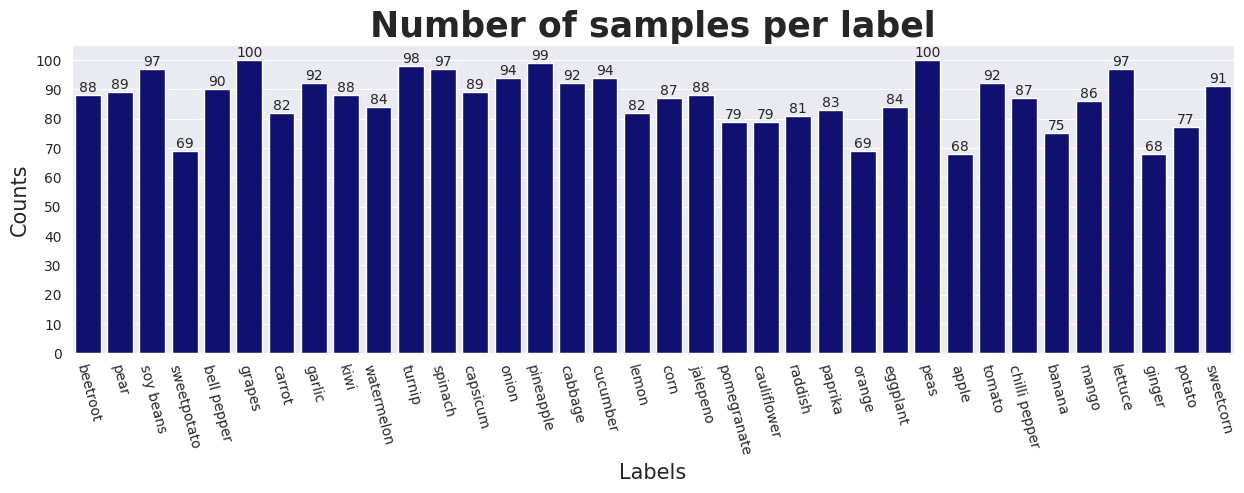

In [ ]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

In [ ]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [ ]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [ ]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 3115
Number of samples in validation : 351
Number of samples test : 359


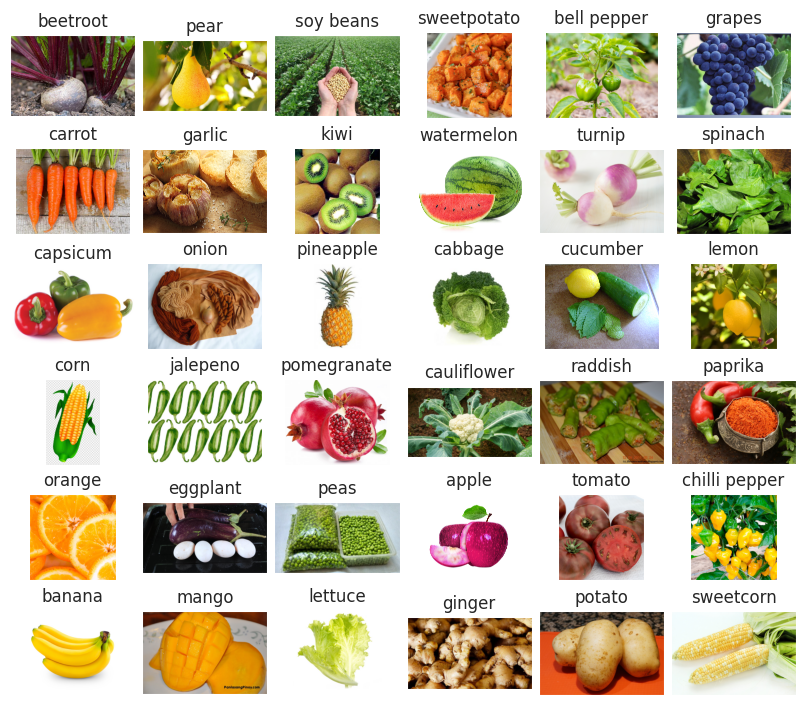

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,

)


Found 3115 validated image filenames belonging to 36 classes.


In [ ]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 351 validated image filenames belonging to 36 classes.


In [ ]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 359 validated image filenames belonging to 36 classes.


In [ ]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False


In [ ]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))


In [ ]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 36)                4644      
                                                                 
Total params: 2623460 (10.01 MB)
Trainable params: 1251556 (4.77 MB)
Non-trainable params: 1371904 (5.23 MB)
_____________

In [ ]:
# Compile
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/20
98/98 [==============================] - 128s 1s/step - loss: 0.1458 - accuracy: 0.9457 - val_loss: 0.5080 - val_accuracy: 0.9117 - lr: 5.0000e-04
Epoch 2/20
98/98 [==============================] - 119s 1s/step - loss: 0.1426 - accuracy: 0.9477 - val_loss: 0.3352 - val_accuracy: 0.9459 - lr: 5.0000e-04
Epoch 3/20
98/98 [==============================] - 125s 1s/step - loss: 0.1274 - accuracy: 0.9512 - val_loss: 0.3931 - val_accuracy: 0.9316 - lr: 5.0000e-04
Epoch 4/20
98/98 [==============================] - 117s 1s/step - loss: 0.1166 - accuracy: 0.9554 - val_loss: 0.5244 - val_accuracy: 0.9060 - lr: 5.0000e-04
Epoch 5/20
98/98 [==============================] - 115s 1s/step - loss: 0.1387 - accuracy: 0.9502 - val_loss: 0.5815 - val_accuracy: 0.9202 - lr: 5.0000e-04
Epoch 6/20
98/98 [==============================] - 117s 1s/step - loss: 0.0954 - accuracy: 0.9644 - val_loss: 0.3629 - val_accuracy: 0.9487 - lr: 2.5000e-04
Epoch 7/20
98/98 [==============================] - 

In [ ]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,loss,accuracy,val_loss,val_accuracy,lr
15,0.053067,0.980096,0.129761,0.974359,0.000250
16,0.043638,0.983628,0.166569,0.968661,0.000250
17,0.050145,0.978491,0.147140,0.974359,0.000250
18,0.055544,0.978491,0.161919,0.971510,0.000250
19,0.050379,0.979775,0.140418,0.971510,0.000125


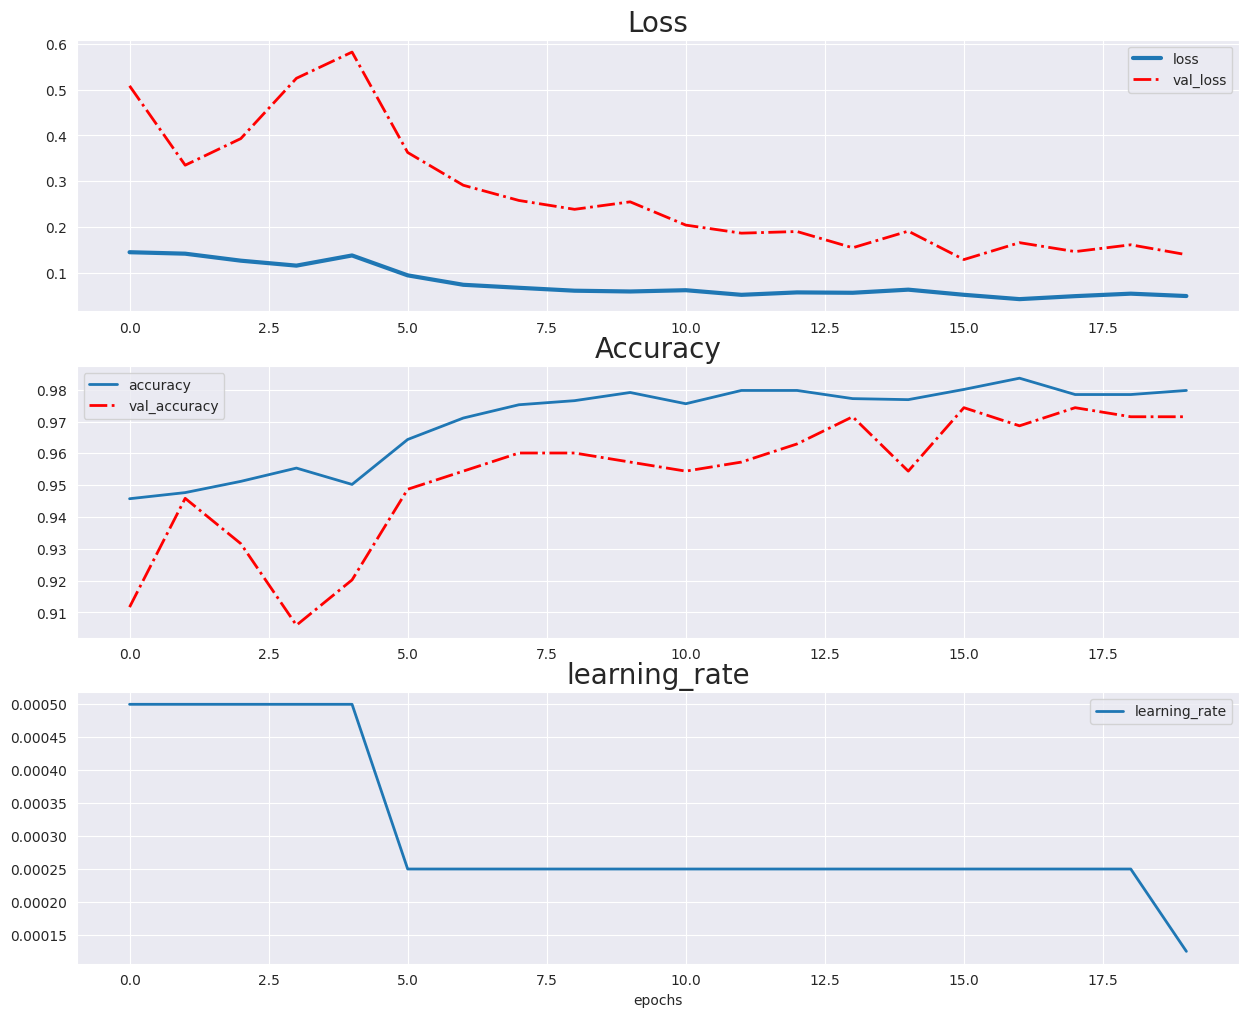

In [ ]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.lr, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()


In [ ]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it
best_model = models.load_model('/content/MyModel.keras')


In [ ]:
test_loss, test_acc = best_model.evaluate_generator(test_generator)

print(colored(f'Test Loss : {round(test_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Accuracy : {round(test_acc, 3)}', 'green', attrs=['bold']))

Test Loss : 0.127
Test Accuracy : 0.975


In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


11/11 [==============================] - 12s 1s/step
               precision    recall  f1-score   support

        apple       0.90      0.90      0.90        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.89      0.94         9
      cabbage       1.00      1.00      1.00        10
     capsicum       0.91      1.00      0.95        10
       carrot       1.00      0.89      0.94         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.75      1.00      0.86         9
         corn       0.83      1.00      0.91        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      1.00      1.00         9
         ki

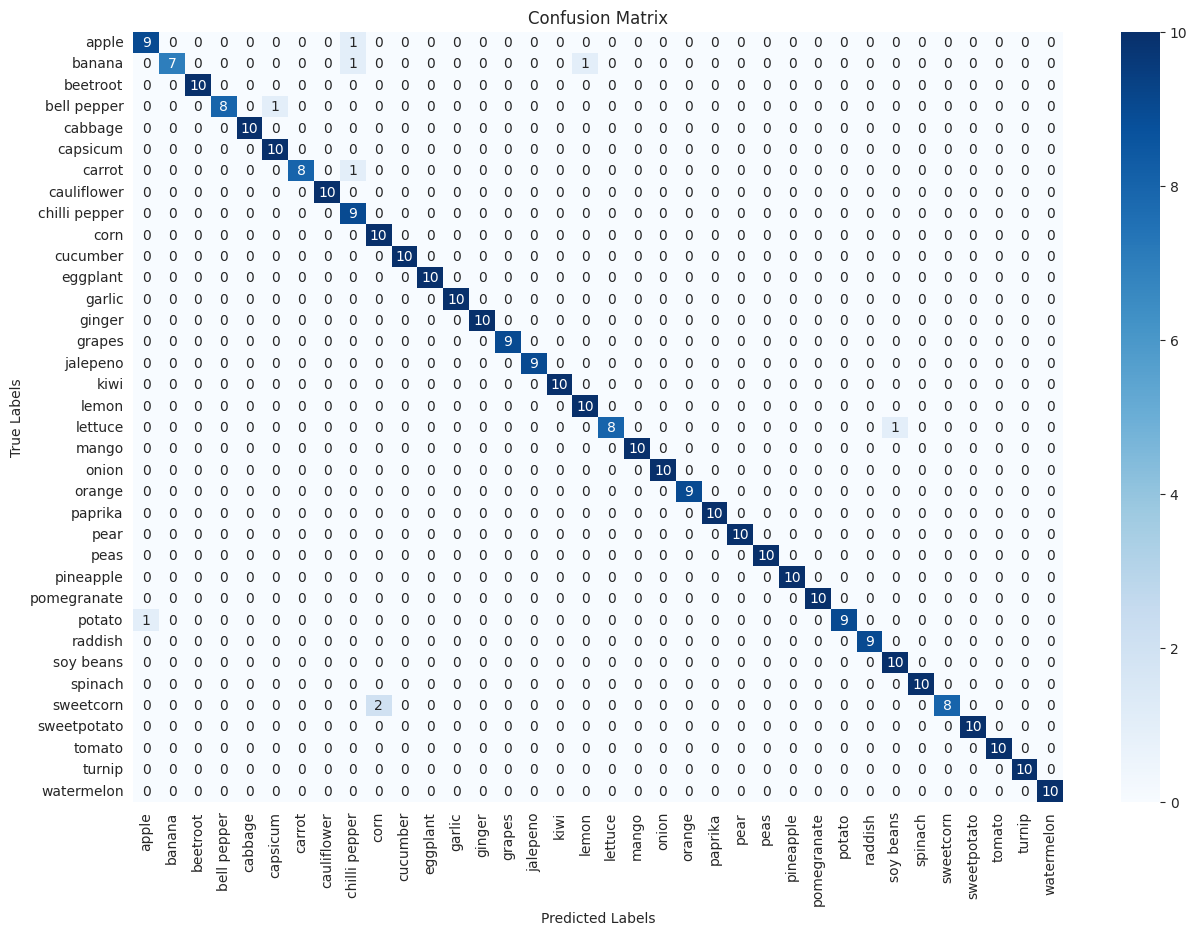

In [ ]:
evaluate_model_performance(best_model, validation_generator, classes)


In [ ]:
import tensorflow as tf

# Load the model
model_path = "/content/MyModel.keras"  # Replace with your model path
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully")


Model loaded successfully


In [ ]:
import os

# Path to the dataset directory
dataset_dir = '/content/train'  # Adjust this to the correct path

# Get the list of all class names (subdirectories) in the dataset directory
class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# Assign an index to each class name
class_indices = {class_name: index for index, class_name in enumerate(class_names)}

# Print the class names and their respective indices
print("Class names and their respective indices:")
for class_name, index in class_indices.items():
    print(f"{index}: {class_name}")



Class names and their respective indices:
0: apple
1: banana
2: beetroot
3: bell pepper
4: cabbage
5: capsicum
6: carrot
7: cauliflower
8: chilli pepper
9: corn
10: cucumber
11: eggplant
12: garlic
13: ginger
14: grapes
15: jalepeno
16: kiwi
17: lemon
18: lettuce
19: mango
20: onion
21: orange
22: paprika
23: pear
24: peas
25: pineapple
26: pomegranate
27: potato
28: raddish
29: soy beans
30: spinach
31: sweetcorn
32: sweetpotato
33: tomato
34: turnip
35: watermelon


In [ ]:
# Define the dictionary with calorie information
food_calories = {
    'Apple': 52,
    'Banana': 89,
    'Orange': 47,
    'Strawberry': 32,
    'Grapes': 69,
    'Watermelon': 30,
    'Pineapple': 50,
    'Mango': 60,
    'Kiwi': 61,
    'Peach': 39,
    'Pear': 57,
    'Cherry': 50,
    'Plum': 46,
    'Blueberry': 57,
    'Raspberry': 52,
    'Cantaloupe': 34,
    'Honeydew Melon': 36,
    'Grapefruit': 42,
    'Pomegranate': 83,
    'Avocado': 160,
    'Carrot': 41,
    'Broccoli': 34,
    'Spinach': 23,
    'Lettuce': 15,
    'Tomato': 18,
    'Cucumber': 16,
    'Green Bell Pepper': {
        'Green': 20,
        'Red': 31,
        'Yellow': 27
    },
    'Onion': 40,
    'Garlic': 149,  # Per 100 grams, usually consumed in smaller amounts
    'Potato': 77,
    'Sweet Potato': 86,
    'Zucchini': 17,
    'Eggplant': 25,
    'Cabbage': 25,
    'Green Beans': 31,
    'Peas': 81,
    'Asparagus': 20,
    'Celery': 16
}

In [ ]:
# Load your trained model
# Example: Replace with your model loading code
model = tf.keras.models.load_model('/content/MyModel.keras')

In [ ]:
# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [ ]:
# Function to predict the food item from an image
def predict_food_item(img_path, model):
    target_size = (224, 224)  # Adjust based on your model's input size
    img_array = preprocess_image(img_path, target_size)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Mapping of class indices to food names
    class_names = list(food_calories.keys())
    predicted_food_item = class_names[predicted_class_index]

    return predicted_food_item, predictions

In [ ]:
# Example usage:
img_path = '/content/test/apple/Image_1.jpg'  # Replace with your carrot image path
predicted_food, predictions = predict_food_item(img_path, model)

1/1 [==============================] - 0s 37ms/step


In [ ]:
# Print predictions for debugging
print(f"All Predictions: {predictions}")

All Predictions: [[9.99998808e-01 1.99513211e-16 2.26869044e-12 9.73050714e-14
  6.43525407e-17 1.91543587e-11 2.53920774e-17 4.95903980e-19
  3.76960407e-11 8.56516010e-17 5.69511072e-14 2.93468964e-15
  4.60138506e-17 1.88962674e-20 1.21382648e-15 8.43863347e-12
  1.81169760e-14 4.69744525e-15 1.86193823e-17 3.19467694e-12
  5.03759035e-13 5.11636983e-11 2.50854726e-10 1.82072268e-09
  2.63826129e-19 9.61447299e-16 1.16482772e-06 2.82001036e-14
  8.18607064e-13 2.36697428e-16 1.04395489e-13 7.19044201e-18
  1.07584905e-17 1.24713503e-11 2.19870151e-12 2.89265167e-13]]


In [ ]:
# Ensure predicted_food is a string
if isinstance(predicted_food, str):
    # Get the calorie content for the predicted food item
    calories = food_calories.get(predicted_food, 'Calorie information not available')
    if isinstance(calories, dict):
        # Handle case where there are multiple varieties (e.g., different colors of bell peppers)
        print(f"Predicted Food Item: {predicted_food}")
        for color, cal in calories.items():
            print(f"   {color}: {cal} kcal per 100g")
    else:
        print(f"Predicted Food Item: {predicted_food}")
        print(f"Calories: {calories} kcal per 100g")
else:
    print("Error: Predicted food item is not a string.")

Predicted Food Item: Apple
Calories: 52 kcal per 100g


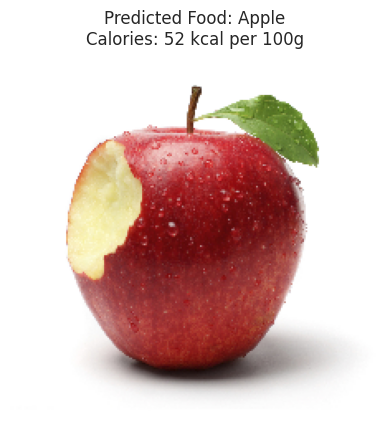

In [ ]:
# Display the image with the predicted food item and calorie content
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size if necessary
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Food: {predicted_food}\nCalories: {calories} kcal per 100g")
plt.show()